<a href="https://colab.research.google.com/github/asegura4488/CienciaDatos/blob/main/Semana6/EstudioRedNeuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import seaborn as sns
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/Cursos/CursoCienciaDatos/Semana6')
!ls

Datos  EstudioRedNeuronal.ipynb  SegmentacionImagenes.ipynb


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC as KerasAUC

In [4]:
# Carga de Data
df = pd.read_csv('Datos/Churn_Modelling.csv')
#df

In [5]:
# Limpiar columnas no predictoras
for col in ['RowNumber', 'CustomerId', 'Surname']:
    df.drop(col, axis=1, inplace=True)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [6]:
# La funcion a predecir
y = df['Exited'].astype(int)
# Feature engineering
x = df.drop(columns='Exited')

In [7]:
# one-hot encoding para las categoricas
X = pd.get_dummies(x, drop_first=True)
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,False,False,True
9997,709,36,7,0.00,1,0,1,42085.58,False,False,False
9998,772,42,3,75075.31,2,1,0,92888.52,True,False,True


<Axes: ylabel='Frequency'>

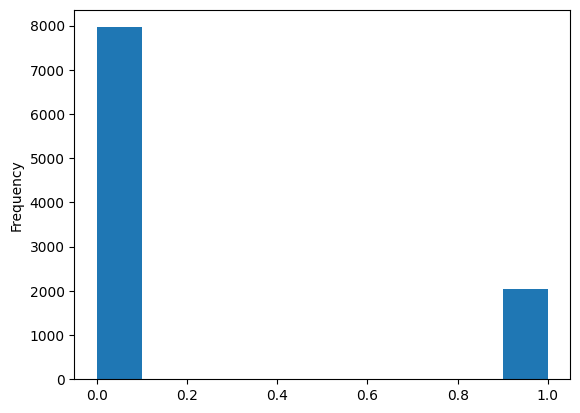

In [8]:
y.plot(kind='hist')
# Hay un desbalance en las clases

In [9]:
X.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [26]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
train = X_train.copy()
train["Exited"] = y_train.values

clase0 = train[train["Exited"] == 0]
clase1 = train[train["Exited"] == 1]

n_min = len(clase1)

clase_down = clase0.sample(n=n_min, random_state=42)
print(clase_down.shape)
train_bal = pd.concat([clase_down, clase1]).sample(frac=1, random_state=42)

y_train = train_bal["Exited"].astype(int)
X_train = train_bal.drop(columns=["Exited"])


(1630, 12)


(array([1630.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1630.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

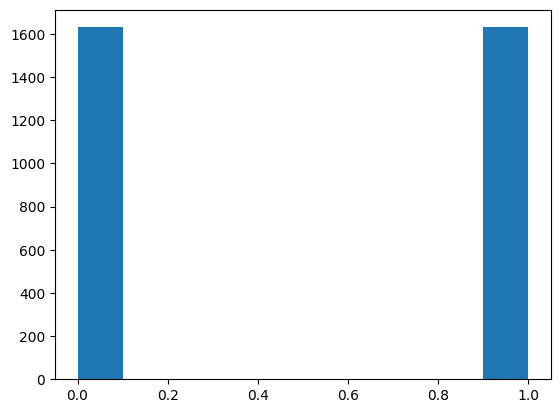

In [30]:
plt.hist(y_train.values)

In [31]:
# Escalar todas las variables
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [32]:
# Modelo de Keras
model = Sequential([
    Dense(20,activation='relu', input_shape=(X_train_s.shape[1],)),
    Dropout(0.1),
    Dense(20,activation='relu'),
    Dropout(0.1),
    Dense(1,activation='sigmoid')
]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', KerasAUC(name='auc')]
)

In [34]:
# Early stopping y entrenamiento
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(
    X_train_s,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5957 - auc: 0.6411 - loss: 0.6646 - val_accuracy: 0.6360 - val_auc: 0.6923 - val_loss: 0.6397
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6596 - auc: 0.7089 - loss: 0.6303 - val_accuracy: 0.6851 - val_auc: 0.7335 - val_loss: 0.6157
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6699 - auc: 0.7147 - loss: 0.6213 - val_accuracy: 0.6922 - val_auc: 0.7554 - val_loss: 0.5971
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6982 - auc: 0.7457 - loss: 0.6005 - val_accuracy: 0.6943 - val_auc: 0.7692 - val_loss: 0.5825
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6981 - auc: 0.7634 - loss: 0.5812 - val_accuracy: 0.7035 - val_auc: 0.7795 - val_loss: 0.5700
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7304 - auc: 0.7916 - loss: 0.5604 - val_accuracy: 0.7035 - val_auc: 0.7841 - val_loss: 0.5623
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

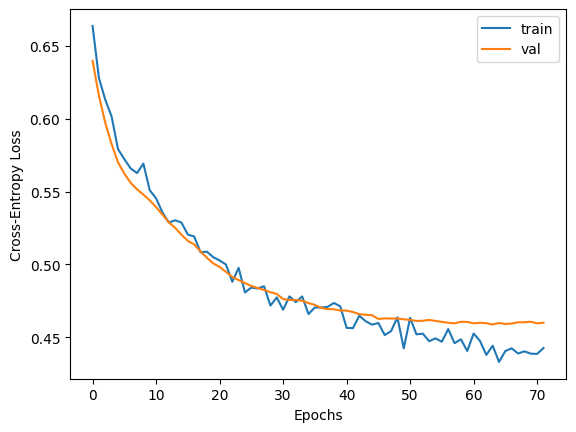

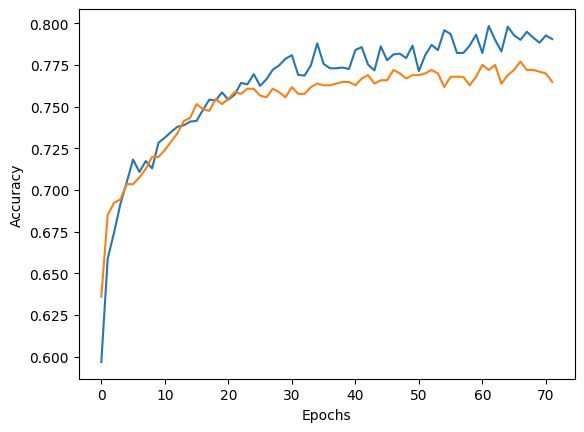

In [35]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.show()

if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.figure()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [36]:
# Estudiar las metricas asociadas a la construcción del modelo
y_proba = model.predict(X_test_s).ravel()
y_proba

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


array([0.06405608, 0.13833937, 0.17972559, ..., 0.97464156, 0.06816097,
       0.33221105], dtype=float32)

In [37]:
# AUC
test_auc = roc_auc_score(y_test, y_proba)
print(f'Test AUC: {test_auc:.4f}')

Test AUC: 0.8587


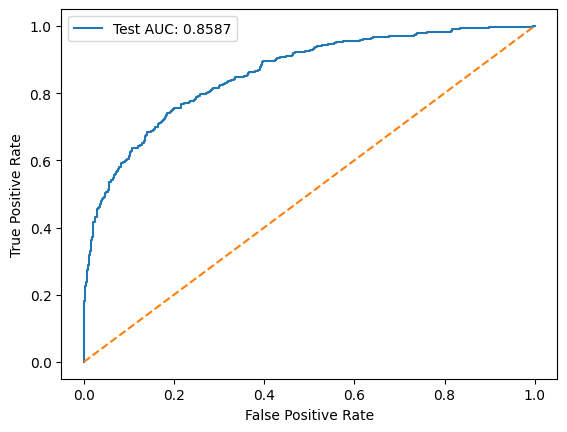

In [38]:
# Mirar la curva roc
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Test AUC: {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [42]:
# Umbralizar el modelo en un valor de la predicción (Hiperparametro)
y_pred = (y_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.930     0.764     0.839      1593
           1      0.457     0.776     0.575       407

    accuracy                          0.766      2000
   macro avg      0.694     0.770     0.707      2000
weighted avg      0.834     0.766     0.785      2000



In [44]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[1217,  376],
       [  91,  316]])

In [45]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')
  #print(cm)

  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j]>thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization


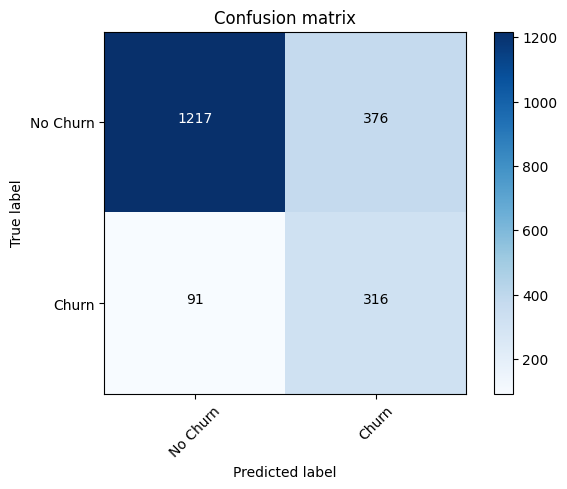

In [46]:
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'])

In [65]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

rows = []

for t in thresholds:

  y_pred = (y_proba >= t).astype(int)

  # matriz de confusion
  tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

  print(tn,fp,fn,tp)
  # Metricas
  acc = (tp+tn)/(tp+tn+fp+fn)
  prec = tp / (tp + fp) if (tp + fp) > 0 else 0
  rec = tp / (tp + fn) if (tp + fn) > 0 else 0
  fpr_v = fp / (fp + tn) if (fp + tn) > 0 else 0
  f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
  print(acc,prec,rec,fpr_v,f1)

  rows.append([t,acc,prec,rec,fpr_v,f1])

df_metrics = pd.DataFrame(rows)
df_metrics

316 1277 7 400
0.358 0.2385211687537269 0.9828009828009828 0.8016321406151915 0.3838771593090211
634 959 18 389
0.5115 0.28857566765578635 0.9557739557739557 0.6020087884494664 0.4433048433048433
883 710 38 369
0.626 0.34198331788693237 0.9066339066339066 0.44569993722536094 0.49663526244952894
1073 520 67 340
0.7065 0.3953488372093023 0.8353808353808354 0.32642812303829255 0.5367008681925809
1217 376 91 316
0.7665 0.45664739884393063 0.7764127764127764 0.23603264281230382 0.5750682438580528
1350 243 127 280
0.815 0.5353728489483748 0.687960687960688 0.15254237288135594 0.6021505376344086
1445 148 164 243
0.844 0.6214833759590793 0.597051597051597 0.09290646578782172 0.6090225563909774
1519 74 205 202
0.8605 0.7318840579710145 0.4963144963144963 0.04645323289391086 0.5915080527086384
1571 22 274 133
0.852 0.8580645161290322 0.32678132678132676 0.013810420590081607 0.47330960854092524


,0,1,2,3,4,5
0,0.1,0.3580,0.238521,0.982801,0.801632,0.383877
1,0.2,0.5115,0.288576,0.955774,0.602009,0.443305
2,0.3,0.6260,0.341983,0.906634,0.445700,0.496635
3,0.4,0.7065,0.395349,0.835381,0.326428,0.536701
4,0.5,0.7665,0.456647,0.776413,0.236033,0.575068
5,0.6,0.8150,0.535373,0.687961,0.152542,0.602151
6,0.7,0.8440,0.621483,0.597052,0.092906,0.609023
7,0.8,0.8605,0.731884,0.496314,0.046453,0.591508
8,0.9,0.8520,0.858065,0.326781,0.013810,0.473310


In [66]:
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_proba)
thr_all = np.concatenate(([0.0], thr, [1.0]))

f1_vals = []
for t in thr_all:
  y_pred = (y_proba >= t).astype(int)
  f1_vals.append(f1_score(y_test, y_pred, zero_division=0))

In [68]:
#¿Como encontramos el maximo?
best_idx = int( np.argmax(f1_vals) )
best_t = float(thr_all[best_idx])
best_f1 = float(f1_vals[best_idx])
print(best_t, best_f1)

0.6683594584465027 0.6188769414575866


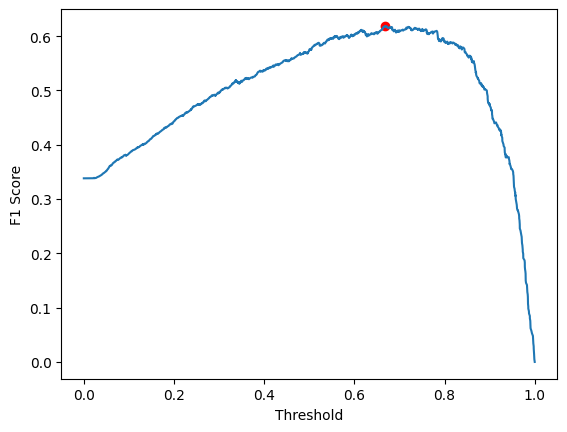

In [69]:
f1_vals = np.array(f1_vals)

plt.figure()
plt.plot(thr_all, f1_vals)
plt.scatter([best_t],[best_f1],color='r')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

Confusion matrix, without normalization


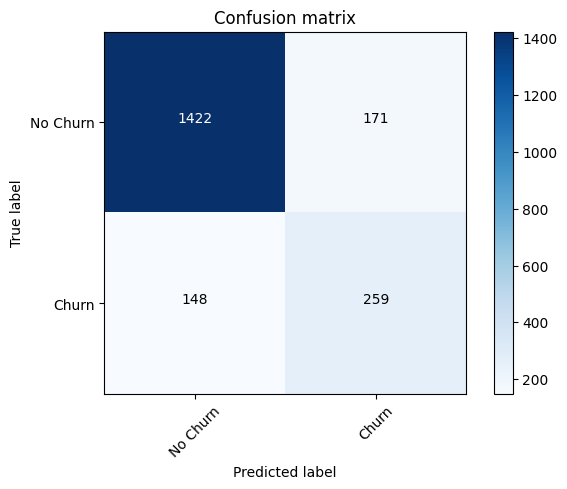

In [72]:
cm = confusion_matrix(y_test, (y_proba >= best_t).astype(int))
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'])